In [2]:
import os,re
import shutil
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.pylab import mpl
import struct
import serial
from pathlib import Path

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
g = 9.801538877

def move_dir(src,dest):
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.move(src,dest)
def split_pro(data):
    split_symbol = [' ',',','，']
    for symbol in split_symbol:
        data = '#*#'.join(data.split(symbol))
    return [item for item in data.split('#*#') if item]

In [4]:

def del_empty_folder(path):
    list_delFolder = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path,folder)
        if os.path.isdir(folder_path):
            del_empty_folder(folder_path)
            if not os.listdir(folder_path):
                os.rmdir(folder_path)
                list_delFolder.append(folder)
    return list_delFolder

def extract_number(filename):
    match = re.search(r'BD(\d+)#',filename)
    return int(match.group(1)) if match else float('inf')
def sort_bd_files(folder_path):
    files = os.listdir(folder_path)
    bd_files = [f for f in files if re.search(r'BD(\d+)#',f)]
    sorted_files = sorted(bd_files,key=extract_number)
    return sorted_files

def fun_lw_average(df,lw_skip,lw_list_sort,bd_skip,bd_list_sort,per=4,ga_shift=3):
    glw_list = []
    gbd_list = []
    alw_list = []
    abd_list = []
    aname_list = []
    fzj_list = []
    axis_name_list = ['x','y','z']
    all_ag_list = [glw_list,gbd_list,alw_list,abd_list]
    for item in all_ag_list:
        for i in range(3):
            item.append([])
    
    df.drop(df.columns[0],axis=1,inplace=True)

    for i in range(3):

        glw_mean = df.iloc[ i*per+lw_skip: (i+1)*per+lw_skip, lw_list_sort[i] ]
        alw_mean = df.iloc[ i*per+lw_skip: (i+1)*per+lw_skip, lw_list_sort[i]+ga_shift ]
        glw_list[lw_list_sort[i]].append(glw_mean.mean())
        alw_list[lw_list_sort[i]].append(alw_mean.mean())

        gbd_mean = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[i] ]
        abd_mean = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[i]+ga_shift ]
        gbd_list[bd_list_sort[i]].append( (gbd_mean[gbd_mean>0].mean()-gbd_mean[gbd_mean<0].mean())/2 )
        abd_list[bd_list_sort[i]].append( (abd_mean[abd_mean>0].mean()-abd_mean[abd_mean<0].mean())/2 )

    for i in range(3):
        if i==0:
            sqrt_gxyz = df.iloc[:,i]**2
            sqrt_axyz = df.iloc[:,i+ga_shift]**2
        else:
            sqrt_gxyz += df.iloc[:,i]**2
            sqrt_axyz += df.iloc[:,i+ga_shift]**2
    
    for i in range(3):
        for j in range(3):
            if i==j:
                continue
            t_name = axis_name_list[bd_list_sort[i]]
            o_name = axis_name_list[bd_list_sort[j]]
            aname = 'K{}{}'.format(o_name,t_name)
            aname_list.append(aname)
            zd_data = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[i]+ga_shift ]
            cd_data = df.iloc[ i*per+bd_skip: (i+1)*per+bd_skip, bd_list_sort[j]+ga_shift ]
            fzj_data = (np.arcsin(cd_data/zd_data)/np.pi*180*60)[-6:].mean()
            fzj_list.append(fzj_data)

    sqrt_gxyz_mean = np.sqrt(sqrt_gxyz.mean())
    sqrt_axyz_mean = np.sqrt(sqrt_axyz.mean())
    return gbd_list,glw_list,abd_list,alw_list,sqrt_gxyz_mean,sqrt_axyz_mean,aname_list,fzj_list

def fun_sl_average(df,gsl_list_sort,sl_list,zf_list):
    all_sl_list = []
    bd_list = [[],[],[]]
    fxxd_list = [[],[],[]]
    gname_list = []
    fzj_list = []


    axis_name_list = ['x','y','z']
    for i in sl_list:
        for j in [1,-1]:
            all_sl_list.append(i*j)
    sl_point_length = len(all_sl_list)
    # print(all_sl_list)
    df.drop(df.columns[0],axis=1,inplace=True)

    for i in range(3):
        bd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i] / 3600 
        # if i==0:
        #     print(list(bd_data))
        data_x = list(bd_data)
        data_y = all_sl_list
        fits = np.polyfit(data_y,data_x,1)
        # erros = data_x - data_y*fits[0]-fits[1]
        erros = [ data_x[i] - data_y[i]*fits[0]-fits[1] for i in range(len(data_x))]
        bd_list[gsl_list_sort[i]].append(fits[0])
        fxxd_list[gsl_list_sort[i]].append( float((pd.DataFrame(erros).abs().max()/fits[0]*1e6/180).iloc[0]) )
    for i in range(3):
        for j in range(3):
            if i==j:
                continue
            t_name = axis_name_list[gsl_list_sort[i]]
            o_name = axis_name_list[gsl_list_sort[j]]
            gname = 'K{}{}'.format(o_name,t_name)
            gname_list.append(gname)
            zd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i]
            cd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[j] ] * zf_list[i]
            fzj_data = (np.arcsin(cd_data/zd_data)/np.pi*180*60)[-6:].mean()
            fzj_list.append(fzj_data)

    return bd_list, fxxd_list, gname_list, fzj_list


In [ ]:
class struct_paraCal:
    def __init__(self):
        self.init_list()
        self.init_conf()
        
    def init_list(self):
        # 初始化测试结果变量
        self.list_SL = []
        self.list_SL_FFZ = []
        self.list_BD_PPM = []
        self.list_LW = []
        self.list_LW_FFZ = []
        self.list_LW_PPM = []
        self.list_LW_STD = []
        self.list_JT = []
        self.list_JT_FFZ = []
        self.list_JT_Allan = []
        self.list_JT_10s = []
        self.list_JT_ns = []
        self.list_FXXD = []
        self.list_FXXD_FFZ = []
        self.list_FXXD_PPM = []
        self.list_FXXD_PPM = []
        self.list_FXXD_STD = []
        self.list_Kxn = []
        self.list_Kyn = []
        self.list_Kzn = []
        self.list_sqrt = []
        
    def init_conf(self):
        # 初始化全局变量
        # 当地属性
        self.longitude = 116.50271
        self.latitude = 39.73155
        self.G = 9.801538877
        # 标度因数相关
        self.SL_name = ['SL','s_average.txt']
        self.SL_sort = [2,1,0]
        self.SL_skipNum = 0
        self.SL_rShiftNum = 1
        self.SL_point_count = [10,10,10]
        self.SL_point_list = [10,50,100,150,180]
        self.SL_point_list = [10,50,90]
        self.SL_point_zf = [1,1,1]
        # 零位相关
        self.LW_name = ['LW','s_average.txt']
        self.LW_GxyzSkipNum = 0
        self.LW_GxyzSort = [0,1,2]
        self.LW_AxyzSkipNum = 4
        self.LW_AxyzSort = [2,0,1]
        self.LW_GAxyzPerCount = 4
        # 静态相关
        self.JT_name = ['JT','s_average.txt']
        self.JT_rolls_num = 1
        # 归一化处理 加速度单位：m/s^2；角速度单位：rad/s。 温度:℃
        self.num_GxyzShift = 4
        self.Gxyz_paraMult = [0.092,0.092,0.092]
        # self.Gxyz_paraMult = [1,1,1]
        self.num_AxyzShift = 1
        self.Axyz_paraMult = [0.00126,0.00126,0.00126]
        # self.Axyz_paraMult = [1,1,1]
        self.num_GxyzTempShift = 7
        self.Gtemp_paraMult = [0.01,0.01,0.01]
        self.num_AxyzTempShift = 10
        self.Atemp_paraMult = [0.01,0.01,0.01]
        self.num_saveDecimal = 6
        self.num_Hz = 10
        # 配置内容
        self.list_showMsg = []
        self.list_debugMsg = []
        self.flag_delEmptyFolder = 1
        self.flag_saveSecondAverage = 1
        self.flag_saveHzAverage = 1
        self.flag_onlySaveXYZ = 1
        self.list_GAGtAt = [
            'Turntable',
            'Gx(deg/h)','Gy(deg/h)','Gz(deg/h)',
            'Ax(m/s2)','Ay(m/s2)','Az(m/s2)',
            'GxTemp','GyTemp','GzTemp',
            'AxTemp','AyTemp','AzTemp',
            'Length','Other'
            ]
        # 尽可能多的取整数圈
        self.num_remainderSL = 36
        self.num_remainderLW = 10
        self.num_remainderMax = 3600
        
    def load_BD_file(self,paths):
        # self.processing_BD_file(paths,mode='ave')
        try: self.processing_BD_file(paths,mode='ave')
        except Exception as e: self.list_showMsg.append('Exceprion [processing_BD_file]:{}'.format(e))
        try: self.processing_BD_file(paths,mode='std')
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_file]:{}'.format(e))
        try: self.processing_BD_SL(paths)
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_SL]:{}'.format(e))
        try: self.processing_BD_LW(paths)
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_LW]:{}'.format(e))
        
    def processing_BD_ave(self,paths):
        try: self.processing_BD_file(paths,mode='ave')
        except Exception as e: self.list_showMsg.append('Exceprion [processing_BD_ave]:{}'.format(e))
    def processing_BD_std(self,paths):
        try: self.processing_BD_file(paths,mode='std')
        except Exception as e: self.list_showMsg.append('Exception [processing_BD_std]:{}'.format(e))
    def processing_BD_SL(self,paths):
        try: self.load_SL_file(paths)
        except Exception as e:self.list_showMsg.append('Exception [processing_BD_SL]:{}'.format(e))
    def processing_BD_LW(self,paths):
        try: self.load_LW_file(paths)
        except Exception as e:self.list_showMsg.append('Exception [processing_BD_LW]:{}'.format(e))
        
        
    # 查看全局变量
    def show_dict(self):
        for i in self.__dict__:
            if 'list' not in i:
                print('{}\t{}'.format(i,self.__dict__[i]))
        pass
    # 初始化变量列表 将数字转列表
    def get_all2List(self,lists=None):
        if isinstance(lists,list):
            init_num_list = lists
        else:
            return False
        for item_count in range(len(init_num_list)):
            item = init_num_list[item_count]
            if isinstance(item,int):
                init_num_list[item_count] = [item,item+1,item+2]
            elif isinstance(item,list):
                for i in range(3):
                    try:item[i]
                    except:init_num_list[item_count].append(item[i-1])
            else:
                print('格式错误:{}'.format(item))
        return init_num_list
        
    # 平均处理标定数据
    def processing_BD_file(self,paths,mode='ave'):
        load_paths = Path(paths)
        if mode=='ave':
            processMode = 'ave'
            std_num = ''
        elif mode=='std':
            processMode = 'std'
            std_num = 'roll{}s_'.format(self.JT_rolls_num)
        # 删除空文件夹
        if self.flag_delEmptyFolder:
            list_delFolder = del_empty_folder(load_paths)
            for msg in list_delFolder:
                self.list_showMsg.append('删除空文件夹: {}'.format(msg))
        # 删除均值缓存文件夹
        save_path = load_paths/('all_%s'%processMode)
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        for plan_name in os.listdir(load_paths):
            if not os.path.isdir(load_paths/plan_name):
                continue
            # if plan_name=='all_%s'%processMode:
            #     continue
            if plan_name.startswith('all_'):
                continue
            list_all_file = [f for f in os.listdir(load_paths/plan_name) if re.search(r'BD(\d+)#',f)]
            list_hzFile = [i for i in list_all_file if ('hz.txt' in i)]
            list_sFile = [i for i in list_all_file if ('s.txt' in i)]
            if (len(list_sFile)==0) & (len(list_hzFile)==0):
                self.list_showMsg.append('没有找到符合格式的文件: {}，默认作为秒值处理'.format(plan_name))
                list_sFile = list_all_file
                list_hzFile = []
                
            if list_hzFile :
                if self.flag_saveHzAverage:
                    save_file_hz = save_path/'{}_{}_{}hz.txt'.format(plan_name,processMode,std_num)
                    list_hzFile = sorted(list_hzFile,key=extract_number)
            if list_sFile :
                if self.flag_saveSecondAverage:
                    save_file_s = save_path/'{}_{}_{}s.txt'.format(plan_name,processMode,std_num)
                    list_sFile = sorted(list_sFile,key=extract_number)
                    
            for filename in list_hzFile+list_sFile:
                if 'hz.txt' in filename:
                    Hz = self.num_Hz
                    save_name = save_file_hz
                else:
                    Hz = 1
                    save_name = save_file_s
                try:
                    files = pd.read_csv(load_paths/plan_name/filename,sep='\\s+',header=None,skiprows=1, encoding='gb2312')
                except:
                    self.list_showMsg.append('打开文件失败: {}',format(filename))
                    continue
                # 设置取均值操作时的文件长度
                if ('spd[' in filename):
                    turn_table = filename.split('spd[')[1].split(']')[0]
                    mean_length = -self.num_remainderSL*Hz*(files.shape[0]//(self.num_remainderSL*Hz))
                elif ('loc[' in filename):
                    turn_table = filename.split('loc[')[1].split(']')[0]
                    mean_length = -self.num_remainderLW*Hz*(files.shape[0]//(self.num_remainderLW*Hz))
                else:
                    turn_table = 'None'
                    mean_length = None
                if abs(mean_length)<10:
                    mean_length = None
                if mean_length:
                    if self.num_remainderMax*Hz<-mean_length:
                        mean_length = -self.num_remainderMax*Hz
                        
                        
                # 根据全局变量归一化处理数据
                init_num_list = [
                    self.num_GxyzShift,
                    self.num_AxyzShift,
                    self.num_GxyzTempShift,
                    self.num_AxyzTempShift
                ]
                init_num_list = self.get_all2List(init_num_list)
                init_para_list = [
                    self.Gxyz_paraMult,
                    self.Axyz_paraMult,
                    self.Gtemp_paraMult,
                    self.Atemp_paraMult
                ]
                init_para_list = self.get_all2List(init_para_list)
                # 仅保存陀螺加表及对应温度\
                if self.flag_onlySaveXYZ:
                    df = pd.DataFrame([])
                    for j in range(len(init_num_list)):
                        for i in range(3): 
                            df = pd.concat([ df,files.iloc[:,init_num_list[j][i]]*init_para_list[j][i] ],axis=1)
                # 全部保存
                else:
                    for j in range(len(init_num_list)):
                        for i in range(3):
                            files.iloc[:,init_num_list[j][i]] *= init_para_list[j][i]
                    df = files
                    
                # 根据文件长度构造新的列表
                files = df.iloc[mean_length:,:]
                if processMode=='ave':
                    processData = files.mean()
                if processMode=='std':
                    processData = files.mean()
                    for i in range(6):
                        processData.iloc[i] = files.iloc[:,i].rolling(self.JT_rolls_num).mean().std()
                    
                len_data = len(files)
                save_data_list = []
                save_data_list.append(str(turn_table))
                for i in range(len(processData)):
                    save_data_list.append('{:.{}f}'.format(processData.iloc[i],self.num_saveDecimal))
                save_data_list.append(str(len_data))
                
            
                if not os.path.exists(save_name):
                    with open(save_name,encoding='gb2312',mode='w') as f:
                        save_title_list = []
                        for i in range(len(save_data_list)):
                            try:
                                save_title_list.append(self.list_GAGtAt[i])
                            except:
                                save_title_list.append(self.list_GAGtAt[-1])
                        f.write('\t'.join(save_title_list)+'\n')
                with open(save_name,encoding='gb2312',mode='a+') as f:
                    f.write('\t'.join(save_data_list)+'\n')
    
        
        
    # 处理速率文件
    def load_SL_file(self,paths):
        save_path = '{}/{}'.format(paths,'all_para')
        load_path = '{}/{}'.format(paths,'all_ave')
        if not os.path.exists(load_path):
            self.list_showMsg.append('load_SL_file找不到文件夹: {}',format(load_path))
            return False
            
        # 删除速率缓存文件夹
        # if os.path.exists(save_path):
        #     shutil.rmtree(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_name = '{}/{}.txt'.format(save_path,'all_GxyzPara_[SL,BD,FXXD,FZJ]')
        if os.path.exists(save_name):
            os.remove(save_name)
            
        init_num_list = [
            self.num_GxyzShift,
            self.num_AxyzShift,
            self.num_GxyzTempShift,
            self.num_AxyzTempShift
        ]
        init_num_list = self.get_all2List(init_num_list)
        save_title_list = [
            'fileName','GxScale','GyScale','GzScale',
            'GxNonLinear','GyNonLinear','GzNonLinear']
        temp_title_list = ['GxTemp','GyTemp','GzTemp']
        
        listdir = os.listdir(load_path)
        listStxt =[f for f in listdir if 's.txt' in f]
        listHztxt = [f for f in listdir if 'hz.txt' in f]
        if len(listStxt)>=len(listHztxt):
            listdir = listStxt
        else:
            listdir = listHztxt
        
        sorted_list = []
        left_list = []
        list_all_file = [f for f in listdir if re.search(self.SL_name[0],f.upper())]
        for name in list_all_file:
            split_name = name.split('_')
            index = split_name.index(self.SL_name[0])+1
            try:sorted_list.append(name) if int(split_name[index])&False else sorted_list.append(name)
            except:left_list.append(name)
        sorted_list = sorted(
            sorted_list,
            key=lambda item:int(item.split('_')[index])
            )
        sorted_list+= sorted(left_list)
        
        for name in sorted_list:
            try:
                df = pd.read_csv('{}/{}'.format(load_path,name),sep='\\s+',header=None,skiprows=1,encoding='gb2312')
            except:
                self.list_showMsg.append('load_SL_file打开文件失败: {}',format(name))
                continue
            bd_list, fxxd_list, gname_list, fzj_list = fun_sl_average(df,self.SL_sort,self.SL_point_list,self.SL_point_zf)
            GxyzTemp = df.iloc[:,init_num_list[2][0]:init_num_list[2][-1]+1].mean()
            if not os.path.exists(save_name):
                save_title_list+=gname_list+temp_title_list
                with open(save_name,encoding='gb2312',mode='w') as f:
                    f.write('\t'.join(save_title_list)+'\n')
            save_data_list = []
            save_data_list.append(name.replace('.txt',''))
            for i in range(len(bd_list)):
                save_data_list.append('{:.{}f}'.format(bd_list[i][0],self.num_saveDecimal))
            for i in range(len(fxxd_list)):
                save_data_list.append('{:.{}f}'.format(fxxd_list[i][0],self.num_saveDecimal))
            for i in range(len(fzj_list)):
                save_data_list.append('{:.{}f}'.format(fzj_list[i],self.num_saveDecimal))
            for i in range(len(GxyzTemp)):
                save_data_list.append('{:.{}f}'.format(GxyzTemp.iloc[i],self.num_saveDecimal))
            with open(save_name,encoding='gb2312',mode='a+') as f:
                f.write('\t'.join(save_data_list)+'\n')
            
    # 处理零位文件
    def load_LW_file(self,paths):
        save_path = '{}/{}'.format(paths,'all_para')
        load_path = '{}/{}'.format(paths,'all_ave')
        if not os.path.exists(load_path):
            self.list_showMsg.append('load_LW_file找不到文件夹: {}',format(load_path))
            return False
            
        # 删除速率缓存文件夹
        # if os.path.exists(save_path):
        #     shutil.rmtree(save_path)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_name = '{}/{}.txt'.format(save_path,'all_para_[LW,GAxyz,JT]')
        if os.path.exists(save_name):
            os.remove(save_name)
        
        init_num_list = [
            self.num_GxyzShift,
            self.num_AxyzShift,
            self.num_GxyzTempShift,
            self.num_AxyzTempShift
        ]
        init_num_list = self.get_all2List(init_num_list)
        
        listdir = os.listdir(load_path)
        listStxt =[f for f in listdir if 's.txt' in f]
        listHztxt = [f for f in listdir if 'hz.txt' in f]
        if len(listStxt)>=len(listHztxt):
            listdir = listStxt
        else:
            listdir = listHztxt
        sorted_list = []
        left_list = []
        list_all_file = [f for f in listdir if re.search(self.LW_name[0],f.upper())]
        for name in list_all_file:
            split_name = name.split('_')
            index = split_name.index(self.LW_name[0])+1
            try:sorted_list.append(name) if int(split_name[index])&False else sorted_list.append(name)
            except:left_list.append(name)
        sorted_list = sorted(
            sorted_list,
            key=lambda item:int(item.split('_')[index])
            )
        sorted_list+= sorted(left_list)
        print(sorted_list)
        
        for name in sorted_list:
            try:
                df = pd.read_csv('{}/{}'.format(load_path,name),sep='\\s+',header=None,skiprows=1,encoding='gb2312')
            except:
                self.list_showMsg.append('load_LW_file打开文件失败: {}',format(name))
                continue
        gbd_list,glw_list,abd_list,alw_list,sqrt_gxyz_mean,sqrt_axyz_mean,aname_list,fzj_list = fun_lw_average(df,self.LW_GxyzSkipNum,self.LW_GxyzSort,self.LW_AxyzSkipNum,self.LW_AxyzSort,self.LW_GAxyzPerCount)
        all_bdlw_list = [gbd_list,glw_list,abd_list,alw_list]
        print(gbd_list)
        print(glw_list)
        print(abd_list)
        print(alw_list)
        pass
    # 处理静态文件
    def load_JT_file(self,paths):
        
        pass
        
test = struct_paraCal()
# test_paths = 'D:\\Data\\D501\\20241122#交付验证#D501#05\\861#05_BD - 副本\\'
test_paths = './data/'
test_paths = './data_129/129#01BD/'
# test.load_BD_file(test_paths)
# test.processing_BD_SL(test_paths)
test.processing_BD_LW(test_paths)
print('showMsgList:')
for msg in test.list_showMsg:
    print(msg)

['LW_-40_2_ave_s.txt', 'LW_-40_ave_s.txt', 'LW_26_2_ave_s.txt', 'LW_26_ave_s.txt', 'LW_60_2_ave_s.txt', 'LW_60_ave_s.txt']
[[9.548956], [9.600200000000001], [9.296462]]
[[0.02272400000000019], [0.4348379999999996], [-0.1617820000000001]]
[[9.900598249999998], [8.5002], [9.798467]]
[[-0.005932999999999999], [0.012271999999999998], [-0.020281]]
showMsgList:


In [9]:
df = pd.read_csv('./data_129/129#01BD/all_ave/LW_-40_2_ave_hz.txt',sep='\\s+',header=None,skiprows=1,encoding='gb2312')
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0_0.0_0.0_0.0,-11.783360,-0.337640,9.531200,-0.050831,0.004773,9.680051,-39.417883,-39.417883,-39.417883,-39.229383,-39.229383,-39.229383,600
1,180.0_0.0_0.0_0.0,11.061773,-3.456747,9.294607,-0.052431,-0.001296,9.680582,-39.550117,-39.550117,-39.550117,-39.232350,-39.232350,-39.232350,600
2,180.0_180.0_0.0_0.0,-11.746407,-3.839773,-9.365907,0.004311,-0.026513,-9.723565,-39.672317,-39.672317,-39.672317,-39.234950,-39.234950,-39.234950,600
3,0.0_180.0_0.0_0.0,11.147487,-0.101813,-9.416200,0.002787,-0.020366,-9.723666,-38.999983,-38.999983,-38.999983,-38.614550,-38.614550,-38.614550,600
4,90.0_0.0_0.0_0.0,-1.676547,-13.177467,9.361153,-0.048159,0.000958,9.681575,-38.659967,-38.659967,-38.659967,-38.167367,-38.167367,-38.167367,600
5,270.0_0.0_0.0_0.0,1.409747,9.515100,9.376333,-0.055270,0.002535,9.681926,-38.454000,-38.454000,-38.454000,-38.058983,-38.058983,-38.058983,600
6,270.0_180.0_0.0_0.0,1.516773,-13.283113,-9.401940,0.000000,-0.023682,-9.723972,-37.975833,-37.975833,-37.975833,-37.517383,-37.517383,-37.517383,600
7,90.0_180.0_0.0_0.0,-2.028293,9.486887,-9.425860,0.006987,-0.022061,-9.724079,-38.049017,-38.049017,-38.049017,-37.542283,-37.542283,-37.542283,600
8,0.0_90.0_0.0_0.0,-9.695727,-0.185687,-11.093513,9.782090,-0.093366,0.001373,-38.133733,-38.133733,-38.133733,-37.617750,-37.617750,-37.617750,600
9,180.0_90.0_0.0_0.0,9.454227,-3.519613,-11.467953,-9.833563,0.074157,-0.046269,-39.408283,-39.408283,-39.408283,-38.633267,-38.633267,-38.633267,600



[10, -10, 50, -50, 90, -90]
          0
0 -1.026749
1 -1.029807
2 -1.027477
3 -1.029024
4 -1.026293
5 -1.027816

[10, -10, 50, -50, 90, -90]
          0
0  1.025067
1  1.025109
2  1.025115
3  1.025118
4  1.025140
5  1.025132

[10, -10, 50, -50, 90, -90]
          0
0 -1.026771
1 -1.026674
2 -1.026726
3 -1.026698
4 -1.026718
5 -1.026705
[[-1.0267116816500519], [1.025131029097482], [-1.0273454851325285]]
[[-1.0959740694158266], [4.37403191025604], [-291.3511542032692]]
[8.496229719608682, 10.445028454468764, -6.809767616346922, -34.599258983458704, -9.007617127820621, 36.090895292504065]


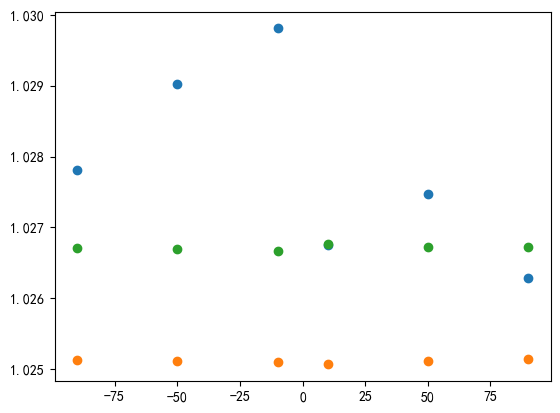

In [ ]:
df = pd.read_csv('./data_129/129#01BD/all_ave/SL_-40_ave_s.txt',sep='\\s+',header=None,skiprows=1,encoding='gb2312')

def fun_sl_average(df,gsl_list_sort,sl_list,zf_list):
    all_sl_list = []
    bd_list = [[],[],[]]
    fxxd_list = [[],[],[]]
    gname_list = []
    fzj_list = []


    axis_name_list = ['x','y','z']
    for i in sl_list:
        for j in [1,-1]:
            all_sl_list.append(i*j)
    sl_point_length = len(all_sl_list)
    # print(all_sl_list)
    df.drop(df.columns[0],axis=1,inplace=True)

    for i in range(3):
        bd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i] / 3600 
        # if i==0:
        #     print(list(bd_data))
        data_x = list(bd_data)
        data_y = all_sl_list
        fits = np.polyfit(data_y,data_x,1)
        # erros = data_x - data_y*fits[0]-fits[1]
        erros = [ data_x[i] - data_y[i]*fits[0]-fits[1] for i in range(len(data_x))]
        bd_list[gsl_list_sort[i]].append(fits[0])
        fxxd_list[gsl_list_sort[i]].append( float((pd.DataFrame(erros).abs().max()/fits[0]*1e6/180).iloc[0]) )
        print()
        if i in [2,0]:
            a = -1
        else:
            a=1
        plt.scatter(pd.DataFrame(data_y),a*pd.DataFrame(data_x)/pd.DataFrame(data_y))
        print(data_y)
        print(pd.DataFrame(data_x)/pd.DataFrame(data_y))
    for i in range(3):
        for j in range(3):
            if i==j:
                continue
            t_name = axis_name_list[gsl_list_sort[i]]
            o_name = axis_name_list[gsl_list_sort[j]]
            gname = 'K{}{}'.format(o_name,t_name)
            gname_list.append(gname)
            zd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[i] ] * zf_list[i]
            cd_data = df.iloc[ i*sl_point_length:(i+1)*sl_point_length, gsl_list_sort[j] ] * zf_list[i]
            fzj_data = (np.arcsin(cd_data/zd_data)/np.pi*180*60)[-6:].mean()
            fzj_list.append(fzj_data)

    return bd_list, fxxd_list, gname_list, fzj_list


bd_list, fxxd_list, gname_list, fzj_list = fun_sl_average(df,[2,1,0],[10,50,90],[1,1,1])
print(bd_list)
print(fxxd_list)
print(fzj_list)

In [27]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-112.903542,-92.372194,-36962.946222,-0.046834,-0.004315,9.679191,-3975.055556,-3975.055556,-3975.055556,-3942.705556,-3942.705556,-3942.705556,36
1,112.444639,88.626292,37073.053069,-0.046123,-0.004301,9.679701,-3940.911111,-3940.911111,-3940.911111,-3910.733333,-3910.733333,-3910.733333,36
2,-561.974611,-461.591278,-184945.935875,0.080608,-0.133392,9.680685,-3932.577778,-3932.577778,-3932.577778,-3894.063889,-3894.063889,-3894.063889,36
3,561.808889,457.583069,185224.360819,0.080363,-0.133182,9.681032,-3900.344444,-3900.344444,-3900.344444,-3859.169444,-3859.169444,-3859.169444,36
4,-1010.479714,-829.424100,-332518.998371,0.376495,-0.434401,9.682524,-3887.320000,-3887.320000,-3887.320000,-3843.562857,-3843.562857,-3843.562857,35
5,1009.642086,825.357829,333012.349929,0.376747,-0.434290,9.682772,-3871.722857,-3871.722857,-3871.722857,-3820.271429,-3820.271429,-3820.271429,35
6,-371.190069,36902.423833,-74.886917,0.151022,-0.010266,-0.867629,-3826.838889,-3826.838889,-3826.838889,-3781.352778,-3781.352778,-3781.352778,36
7,370.404472,-36903.915333,72.866847,0.349514,-0.009853,0.770847,-3787.316667,-3787.316667,-3787.316667,-3738.219444,-3738.219444,-3738.219444,36
8,-1859.193806,184520.784222,-362.637431,0.462266,-0.011064,0.563129,-3774.111111,-3774.111111,-3774.111111,-3715.427778,-3715.427778,-3715.427778,36
9,1861.869375,-184521.212778,363.009778,-0.105249,-0.007144,-0.405461,-3792.330556,-3792.330556,-3792.330556,-3717.977778,-3717.977778,-3717.977778,36
